In [46]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from tqdm import tqdm

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_1328188/1112902026.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


Reading training data
[([ 88, 164,  73,  33,  12, 215,  87,  33, 126, 142,  77,  33,  44, 175,  66, 120,  20, 194, 171,  16, 158,  77,  33,  44, 215,  95,  33,  62, 142,  73,  33,  12], 0, 5417, 0, 0)]
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
lnsgkgsnl/1r5b1/ppppppppp/9/9/9/PPPPPPPPP/1B5R1/LNSGKGSNL b - 1


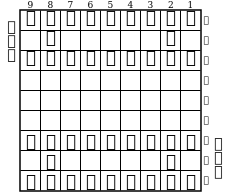

In [82]:
import logging

import torch

import cshogi

import sys
sys.path.append("../scripts")

from dataloader import HcpeDataLoader
from features import feature_to_sfen

batch_size = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print("Reading training data")
train_dataloader = HcpeDataLoader(files="../preprocessed_data/train.hcpe",
                                  batch_size=batch_size,
                                  device=device, 
                                  shuffle=True)


"""
print("Reading test data")
test_dataloader = HcpeDataLoader(files="../preprocessed_data/train.hcpe",
                                 batch_size=batch_size,
                                 device=device)
"""
"""
test_dataloader = HcpeDataLoader(files="../preprocessed_data/initial_position.hcpe",
                                 batch_size=1,
                                 device=device)
"""

mini_batch_data = train_dataloader.data[:1]

print(mini_batch_data)

features, move_label, result = train_dataloader.mini_batch(mini_batch_data)
print(features[0][0])
sfen = feature_to_sfen(features[0])
board = cshogi.Board(sfen)
display(board)

In [3]:
features.shape

torch.Size([1024, 104, 9, 9])

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
bs = batch_size

In [6]:
"""
# Load Data
dataset = datasets.ImageFolder(root='./rollouts', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)
"""

"\n# Load Data\ndataset = datasets.ImageFolder(root='./rollouts', transform=transforms.Compose([\n    transforms.Resize(64),\n    transforms.ToTensor(), \n]))\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)\nlen(dataset.imgs), len(dataloader)\n"

In [7]:
"""
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')
"""

"\n# Fixed input for debugging\nfixed_x, _ = next(iter(dataloader))\nsave_image(fixed_x, 'real_image.png')\n\nImage('real_image.png')\n"

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        # print("Flatten shape", input.shape)
        return input.view(input.size(0), -1)

In [9]:
class UnFlatten(nn.Module):
    # def forward(self, input, size=1024):
    def forward(self, input, size=8424):
        # return input.view(input.size(0), size, 1, 1)
        # print(input.shape)
        # print(input.size(0))
        return input.view(input.size(0), size//81, 9, 9)

In [10]:
class VAE(nn.Module):
    # def __init__(self, channels=3, h_dim=1024, z_dim=32):
    def __init__(self, channels=3, h_dim=8424, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            # nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            # nn.Conv2d(32, 64, kernel_size=3),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            # nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            # nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            # nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ConvTranspose2d(h_dim//81, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            # nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ConvTranspose2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            # nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ConvTranspose2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            # nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.ConvTranspose2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        
        # esp = torch.randn(*mu.size())
        esp = torch.randn(*mu.size()).to(device)
        # print("mu", mu)
        # print("std", std)
        # print("esp", esp)

        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [11]:
# image_channels = fixed_x.size(1)
channels = features.size(1)

In [12]:
model = VAE(channels=channels).to(device)
# model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [13]:
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    beta = 250

    return BCE + beta * KLD, BCE, KLD

In [15]:
# epochs = 50
epochs = 1

In [16]:
for epoch in range(epochs):
    # for idx, (images, _) in enumerate(dataloader):
    # for idx, images in enumerate(features):
    for idx, (images, move_label, result) in enumerate(tqdm(train_dataloader)):
        # recon_images, mu, logvar = vae(images)
        recon_images, mu, logvar = model(images)
        # print("images", images.shape)
        # print("recon_imagets", recon_images.shape)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(loss.data.item())
        # print(bce.data.item())
        # print(kld.data.item())

        # to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
        #                         # epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #                         epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
        # print(to_print)
        if (idx + 1) % 1_000 == 0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                  epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
            print(to_print)

            if (idx + 1) % 300_000 == 0:
                break

# notify to android when finished training
# notify(to_print, priority=1)

torch.save(model.state_dict(), 'vae.torch')

  0%|          | 0/245219048 [00:00<?, ?it/s]

/home/ogawa/.pyenv/versions/miniconda3-latest/envs/world-models-for-board-games/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1003/245219048 [01:07<3214:24:02, 21.19it/s]

Epoch[1/1] Loss: 411.207 409.558 0.007


  0%|          | 2002/245219048 [01:54<3241:33:45, 21.01it/s]

Epoch[1/1] Loss: 253.052 251.283 0.007


  0%|          | 3004/245219048 [02:42<3192:36:15, 21.34it/s]

Epoch[1/1] Loss: 113.939 112.670 0.005


  0%|          | 4003/245219048 [03:29<3225:38:54, 21.12it/s]

Epoch[1/1] Loss: 213.116 211.021 0.008


  0%|          | 5002/245219048 [04:16<3203:04:55, 21.27it/s]

Epoch[1/1] Loss: 109.003 107.626 0.006


  0%|          | 6004/245219048 [05:04<3262:50:23, 20.88it/s]

Epoch[1/1] Loss: 72.138 70.994 0.005


  0%|          | 7003/245219048 [05:51<3175:45:08, 21.45it/s]

Epoch[1/1] Loss: 76.380 75.220 0.005


  0%|          | 8002/245219048 [06:38<3244:19:46, 20.99it/s]

Epoch[1/1] Loss: 85.436 84.288 0.005


  0%|          | 9004/245219048 [07:26<3265:21:17, 20.86it/s]

Epoch[1/1] Loss: 61.268 60.201 0.004


  0%|          | 10003/245219048 [08:14<3279:49:13, 20.77it/s]

Epoch[1/1] Loss: 57.194 56.208 0.004


  0%|          | 11002/245219048 [09:02<3232:06:01, 21.07it/s]

Epoch[1/1] Loss: 54.755 53.668 0.004


  0%|          | 12004/245219048 [09:50<3280:33:45, 20.76it/s]

Epoch[1/1] Loss: 91.173 89.990 0.005


  0%|          | 13003/245219048 [10:37<3249:55:35, 20.96it/s]

Epoch[1/1] Loss: 43.881 42.918 0.004


  0%|          | 14002/245219048 [11:25<3229:39:22, 21.09it/s]

Epoch[1/1] Loss: 44.032 43.055 0.004


  0%|          | 15004/245219048 [12:13<3254:19:39, 20.93it/s]

Epoch[1/1] Loss: 41.040 40.116 0.004


  0%|          | 16003/245219048 [13:00<3174:48:05, 21.45it/s]

Epoch[1/1] Loss: 42.074 41.137 0.004


  0%|          | 17002/245219048 [13:48<3232:05:53, 21.07it/s]

Epoch[1/1] Loss: 66.274 65.088 0.005


  0%|          | 18004/245219048 [14:35<3207:22:57, 21.24it/s]

Epoch[1/1] Loss: 39.904 38.924 0.004


  0%|          | 19003/245219048 [15:23<3195:23:53, 21.32it/s]

Epoch[1/1] Loss: 59.957 58.800 0.005


  0%|          | 20002/245219048 [16:10<3199:31:30, 21.29it/s]

Epoch[1/1] Loss: 36.275 35.295 0.004


  0%|          | 21004/245219048 [16:57<3215:06:16, 21.18it/s]

Epoch[1/1] Loss: 62.829 61.746 0.004


  0%|          | 22003/245219048 [17:44<3243:28:35, 21.00it/s]

Epoch[1/1] Loss: 34.399 33.464 0.004


  0%|          | 23002/245219048 [18:32<3218:58:45, 21.16it/s]

Epoch[1/1] Loss: 64.866 63.937 0.004


  0%|          | 24004/245219048 [19:20<3218:44:29, 21.16it/s]

Epoch[1/1] Loss: 32.991 32.040 0.004


  0%|          | 25003/245219048 [20:08<3206:14:41, 21.24it/s]

Epoch[1/1] Loss: 30.183 29.237 0.004


  0%|          | 26002/245219048 [20:55<3257:59:42, 20.91it/s]

Epoch[1/1] Loss: 30.205 29.260 0.004


  0%|          | 27004/245219048 [21:43<3223:43:11, 21.13it/s]

Epoch[1/1] Loss: 27.424 26.484 0.004


  0%|          | 28003/245219048 [22:31<3331:03:51, 20.45it/s]

Epoch[1/1] Loss: 29.420 28.453 0.004


  0%|          | 29002/245219048 [23:18<3112:40:13, 21.88it/s]

Epoch[1/1] Loss: 28.588 27.651 0.004


  0%|          | 30004/245219048 [24:06<3207:48:29, 21.23it/s]

Epoch[1/1] Loss: 30.517 29.541 0.004


  0%|          | 31003/245219048 [24:53<3215:47:49, 21.18it/s]

Epoch[1/1] Loss: 37.017 36.007 0.004


  0%|          | 32002/245219048 [25:40<3229:26:54, 21.09it/s]

Epoch[1/1] Loss: 26.354 25.400 0.004


  0%|          | 33004/245219048 [26:28<3283:15:23, 20.74it/s]

Epoch[1/1] Loss: 49.647 48.628 0.004


  0%|          | 34003/245219048 [27:16<3250:17:31, 20.95it/s]

Epoch[1/1] Loss: 28.931 27.954 0.004


  0%|          | 35003/245219048 [28:04<3204:24:21, 21.25it/s]

Epoch[1/1] Loss: 30.056 29.055 0.004


  0%|          | 36002/245219048 [28:52<3238:34:17, 21.03it/s]

Epoch[1/1] Loss: 52.523 51.563 0.004


  0%|          | 37004/245219048 [29:39<3264:40:58, 20.86it/s]

Epoch[1/1] Loss: 62.556 61.508 0.004


  0%|          | 38003/245219048 [30:26<3177:02:47, 21.44it/s]

Epoch[1/1] Loss: 26.844 25.875 0.004


  0%|          | 39002/245219048 [31:14<3216:37:18, 21.17it/s]

Epoch[1/1] Loss: 25.030 24.078 0.004


  0%|          | 40004/245219048 [32:01<3274:17:52, 20.80it/s]

Epoch[1/1] Loss: 26.769 25.774 0.004


  0%|          | 41003/245219048 [32:49<3216:05:06, 21.18it/s]

Epoch[1/1] Loss: 24.406 23.456 0.004


  0%|          | 42002/245219048 [33:36<3283:00:55, 20.74it/s]

Epoch[1/1] Loss: 24.320 23.348 0.004


  0%|          | 43004/245219048 [34:24<3247:45:11, 20.97it/s]

Epoch[1/1] Loss: 23.865 22.914 0.004


  0%|          | 44003/245219048 [35:12<3257:06:25, 20.91it/s]

Epoch[1/1] Loss: 41.298 40.185 0.004


  0%|          | 45002/245219048 [36:00<3270:50:46, 20.82it/s]

Epoch[1/1] Loss: 23.297 22.320 0.004


  0%|          | 46004/245219048 [36:48<3216:49:33, 21.17it/s]

Epoch[1/1] Loss: 21.959 21.002 0.004


  0%|          | 47003/245219048 [37:35<3248:21:55, 20.97it/s]

Epoch[1/1] Loss: 39.405 38.402 0.004


  0%|          | 48002/245219048 [38:23<3278:44:59, 20.77it/s]

Epoch[1/1] Loss: 22.517 21.537 0.004


  0%|          | 49004/245219048 [39:11<3200:00:02, 21.28it/s]

Epoch[1/1] Loss: 22.446 21.477 0.004


  0%|          | 50003/245219048 [39:58<3195:37:19, 21.31it/s]

Epoch[1/1] Loss: 21.623 20.635 0.004


  0%|          | 51002/245219048 [40:45<3239:29:47, 21.02it/s]

Epoch[1/1] Loss: 21.192 20.218 0.004


  0%|          | 52004/245219048 [41:33<3223:02:45, 21.13it/s]

Epoch[1/1] Loss: 21.418 20.433 0.004


  0%|          | 53003/245219048 [42:20<3200:59:34, 21.28it/s]

Epoch[1/1] Loss: 23.761 22.712 0.004


  0%|          | 54002/245219048 [43:07<3245:34:52, 20.98it/s]

Epoch[1/1] Loss: 26.764 25.748 0.004


  0%|          | 55004/245219048 [43:54<3229:22:03, 21.09it/s]

Epoch[1/1] Loss: 48.582 47.514 0.004


  0%|          | 56003/245219048 [44:41<3194:15:00, 21.32it/s]

Epoch[1/1] Loss: 34.748 33.728 0.004


  0%|          | 57002/245219048 [45:29<3266:27:31, 20.85it/s]

Epoch[1/1] Loss: 44.397 43.270 0.005


  0%|          | 58004/245219048 [46:16<3275:53:22, 20.79it/s]

Epoch[1/1] Loss: 41.554 40.517 0.004


  0%|          | 59003/245219048 [47:04<3243:57:08, 20.99it/s]

Epoch[1/1] Loss: 41.024 40.011 0.004


  0%|          | 60002/245219048 [47:51<3262:25:30, 20.87it/s]

Epoch[1/1] Loss: 27.088 25.997 0.004


  0%|          | 61004/245219048 [48:39<3275:34:36, 20.79it/s]

Epoch[1/1] Loss: 19.955 18.932 0.004


  0%|          | 62003/245219048 [49:26<3211:30:37, 21.20it/s]

Epoch[1/1] Loss: 21.900 20.834 0.004


  0%|          | 63002/245219048 [50:13<3237:31:52, 21.03it/s]

Epoch[1/1] Loss: 18.156 17.121 0.004


  0%|          | 64004/245219048 [51:01<3198:05:19, 21.29it/s]

Epoch[1/1] Loss: 20.058 19.027 0.004


  0%|          | 65003/245219048 [51:49<3165:13:33, 21.51it/s]

Epoch[1/1] Loss: 71.702 70.592 0.004


  0%|          | 66002/245219048 [52:37<3284:46:30, 20.73it/s]

Epoch[1/1] Loss: 19.279 18.219 0.004


  0%|          | 67004/245219048 [53:25<3262:49:42, 20.87it/s]

Epoch[1/1] Loss: 18.325 17.289 0.004


  0%|          | 68003/245219048 [54:13<3225:41:46, 21.11it/s]

Epoch[1/1] Loss: 27.322 26.212 0.004


  0%|          | 69002/245219048 [55:00<3287:41:56, 20.71it/s]

Epoch[1/1] Loss: 19.966 18.886 0.004


  0%|          | 70004/245219048 [55:48<3283:10:02, 20.74it/s]

Epoch[1/1] Loss: 40.078 38.924 0.005


  0%|          | 71003/245219048 [56:36<3145:09:59, 21.65it/s]

Epoch[1/1] Loss: 18.227 17.166 0.004


  0%|          | 72002/245219048 [57:23<3269:52:25, 20.83it/s]

Epoch[1/1] Loss: 18.303 17.265 0.004


  0%|          | 73004/245219048 [58:11<3264:46:47, 20.86it/s]

Epoch[1/1] Loss: 18.606 17.557 0.004


  0%|          | 74003/245219048 [58:59<3247:21:06, 20.97it/s]

Epoch[1/1] Loss: 18.013 16.963 0.004


  0%|          | 75002/245219048 [59:46<3204:16:49, 21.25it/s]

Epoch[1/1] Loss: 21.048 19.938 0.004


  0%|          | 76004/245219048 [1:00:34<3225:13:59, 21.11it/s]

Epoch[1/1] Loss: 19.872 18.807 0.004


  0%|          | 77003/245219048 [1:01:22<3230:37:56, 21.08it/s]

Epoch[1/1] Loss: 17.230 16.164 0.004


  0%|          | 78002/245219048 [1:02:09<3221:31:15, 21.14it/s]

Epoch[1/1] Loss: 20.051 18.964 0.004


  0%|          | 79004/245219048 [1:02:57<3268:49:48, 20.83it/s]

Epoch[1/1] Loss: 18.420 17.351 0.004


  0%|          | 80003/245219048 [1:03:44<3255:04:09, 20.92it/s]

Epoch[1/1] Loss: 17.234 16.181 0.004


  0%|          | 81002/245219048 [1:04:32<3256:35:54, 20.91it/s]

Epoch[1/1] Loss: 24.912 23.826 0.004


  0%|          | 82004/245219048 [1:05:20<3214:51:43, 21.18it/s]

Epoch[1/1] Loss: 23.800 22.742 0.004


  0%|          | 83003/245219048 [1:06:07<3225:35:18, 21.11it/s]

Epoch[1/1] Loss: 24.639 23.504 0.005


  0%|          | 84002/245219048 [1:06:54<3177:26:48, 21.43it/s]

Epoch[1/1] Loss: 18.099 17.006 0.004


  0%|          | 85004/245219048 [1:07:42<3253:36:04, 20.93it/s]

Epoch[1/1] Loss: 19.001 17.888 0.004


  0%|          | 86003/245219048 [1:08:30<3227:22:09, 21.10it/s]

Epoch[1/1] Loss: 17.066 15.985 0.004


  0%|          | 87002/245219048 [1:09:17<3262:36:51, 20.87it/s]

Epoch[1/1] Loss: 19.184 18.065 0.004


  0%|          | 88004/245219048 [1:10:05<3267:18:10, 20.84it/s]

Epoch[1/1] Loss: 16.939 15.878 0.004


  0%|          | 89003/245219048 [1:10:52<3198:57:51, 21.29it/s]

Epoch[1/1] Loss: 16.546 15.475 0.004


  0%|          | 90002/245219048 [1:11:40<3258:52:44, 20.89it/s]

Epoch[1/1] Loss: 18.010 16.885 0.005


  0%|          | 91004/245219048 [1:12:27<3284:31:02, 20.73it/s]

Epoch[1/1] Loss: 16.069 14.987 0.004


  0%|          | 92003/245219048 [1:13:15<3270:10:45, 20.82it/s]

Epoch[1/1] Loss: 17.627 16.550 0.004


  0%|          | 93002/245219048 [1:14:03<3265:48:47, 20.85it/s]

Epoch[1/1] Loss: 21.279 20.205 0.004


  0%|          | 94004/245219048 [1:14:51<3224:04:13, 21.12it/s]

Epoch[1/1] Loss: 16.794 15.703 0.004


  0%|          | 95003/245219048 [1:15:39<3237:26:41, 21.03it/s]

Epoch[1/1] Loss: 30.071 28.915 0.005


  0%|          | 96002/245219048 [1:16:26<3252:50:09, 20.93it/s]

Epoch[1/1] Loss: 16.965 15.846 0.004


  0%|          | 97004/245219048 [1:17:14<3260:21:14, 20.88it/s]

Epoch[1/1] Loss: 16.603 15.520 0.004


  0%|          | 98003/245219048 [1:18:02<3215:56:54, 21.17it/s]

Epoch[1/1] Loss: 15.783 14.699 0.004


  0%|          | 99002/245219048 [1:18:50<3283:16:07, 20.74it/s]

Epoch[1/1] Loss: 17.319 16.185 0.005


  0%|          | 100004/245219048 [1:19:39<3295:56:07, 20.66it/s]

Epoch[1/1] Loss: 15.787 14.682 0.004


  0%|          | 101003/245219048 [1:20:27<3270:37:26, 20.82it/s]

Epoch[1/1] Loss: 21.697 20.544 0.005


  0%|          | 102002/245219048 [1:21:14<3180:46:48, 21.41it/s]

Epoch[1/1] Loss: 17.085 15.986 0.004


  0%|          | 103004/245219048 [1:22:02<3266:03:06, 20.85it/s]

Epoch[1/1] Loss: 20.497 19.428 0.004


  0%|          | 104003/245219048 [1:22:50<3225:53:36, 21.11it/s]

Epoch[1/1] Loss: 22.733 21.565 0.005


  0%|          | 105002/245219048 [1:23:37<3260:47:36, 20.88it/s]

Epoch[1/1] Loss: 16.009 14.901 0.004


  0%|          | 106004/245219048 [1:24:25<3285:53:45, 20.72it/s]

Epoch[1/1] Loss: 16.115 15.016 0.004


  0%|          | 107003/245219048 [1:25:13<3206:45:50, 21.23it/s]

Epoch[1/1] Loss: 14.879 13.785 0.004


  0%|          | 108002/245219048 [1:26:01<3271:15:43, 20.81it/s]

Epoch[1/1] Loss: 17.318 16.182 0.005


  0%|          | 109004/245219048 [1:26:49<3257:41:11, 20.90it/s]

Epoch[1/1] Loss: 17.730 16.627 0.004


  0%|          | 110003/245219048 [1:27:37<3256:23:37, 20.91it/s]

Epoch[1/1] Loss: 84.810 83.851 0.004


  0%|          | 111002/245219048 [1:28:24<3236:29:59, 21.04it/s]

Epoch[1/1] Loss: 15.767 14.631 0.005


  0%|          | 112004/245219048 [1:29:12<3266:53:54, 20.84it/s]

Epoch[1/1] Loss: 15.807 14.684 0.004


  0%|          | 113003/245219048 [1:30:00<3231:50:53, 21.07it/s]

Epoch[1/1] Loss: 15.181 14.070 0.004


  0%|          | 114002/245219048 [1:30:48<3157:53:30, 21.56it/s]

Epoch[1/1] Loss: 18.436 17.274 0.005


  0%|          | 115004/245219048 [1:31:36<3328:13:59, 20.46it/s]

Epoch[1/1] Loss: 14.576 13.457 0.004


  0%|          | 116003/245219048 [1:32:24<3257:53:07, 20.90it/s]

Epoch[1/1] Loss: 15.343 14.235 0.004


  0%|          | 117002/245219048 [1:33:12<3305:15:48, 20.60it/s]

Epoch[1/1] Loss: 15.717 14.575 0.005


  0%|          | 118004/245219048 [1:34:01<3327:41:56, 20.46it/s]

Epoch[1/1] Loss: 15.783 14.672 0.004


  0%|          | 119003/245219048 [1:34:49<3206:57:13, 21.23it/s]

Epoch[1/1] Loss: 16.321 15.193 0.005


  0%|          | 120002/245219048 [1:35:37<3286:37:32, 20.72it/s]

Epoch[1/1] Loss: 14.971 13.869 0.004


  0%|          | 121004/245219048 [1:36:25<3281:54:37, 20.74it/s]

Epoch[1/1] Loss: 24.427 23.258 0.005


  0%|          | 122003/245219048 [1:37:13<3237:14:53, 21.03it/s]

Epoch[1/1] Loss: 15.828 14.694 0.005


  0%|          | 123002/245219048 [1:38:01<3319:19:17, 20.51it/s]

Epoch[1/1] Loss: 16.866 15.750 0.004


  0%|          | 124004/245219048 [1:38:50<3260:40:49, 20.88it/s]

Epoch[1/1] Loss: 18.597 17.444 0.005


  0%|          | 125003/245219048 [1:39:37<3271:56:18, 20.81it/s]

Epoch[1/1] Loss: 15.525 14.363 0.005


  0%|          | 126002/245219048 [1:40:25<3243:19:26, 20.99it/s]

Epoch[1/1] Loss: 14.200 13.063 0.005


  0%|          | 127004/245219048 [1:41:13<3286:41:23, 20.71it/s]

Epoch[1/1] Loss: 15.985 14.853 0.005


  0%|          | 128003/245219048 [1:42:01<3272:38:42, 20.80it/s]

Epoch[1/1] Loss: 15.254 14.140 0.004


  0%|          | 129002/245219048 [1:42:50<3275:28:51, 20.78it/s]

Epoch[1/1] Loss: 16.620 15.476 0.005


  0%|          | 130004/245219048 [1:43:37<3253:50:29, 20.92it/s]

Epoch[1/1] Loss: 14.787 13.647 0.005


  0%|          | 131003/245219048 [1:44:25<3218:36:39, 21.15it/s]

Epoch[1/1] Loss: 14.668 13.560 0.004


  0%|          | 132002/245219048 [1:45:13<3244:02:08, 20.99it/s]

Epoch[1/1] Loss: 17.634 16.488 0.005


  0%|          | 133004/245219048 [1:46:01<3225:04:24, 21.11it/s]

Epoch[1/1] Loss: 14.896 13.764 0.005


  0%|          | 134003/245219048 [1:46:48<3237:03:49, 21.03it/s]

Epoch[1/1] Loss: 25.975 24.777 0.005


  0%|          | 135002/245219048 [1:47:36<3301:15:21, 20.62it/s]

Epoch[1/1] Loss: 15.793 14.636 0.005


  0%|          | 136004/245219048 [1:48:23<3257:35:06, 20.90it/s]

Epoch[1/1] Loss: 21.869 20.663 0.005


  0%|          | 137003/245219048 [1:49:11<3205:54:34, 21.24it/s]

Epoch[1/1] Loss: 15.270 14.115 0.005


  0%|          | 138002/245219048 [1:49:58<3293:03:20, 20.67it/s]

Epoch[1/1] Loss: 15.392 14.255 0.005


  0%|          | 139004/245219048 [1:50:46<3218:38:35, 21.15it/s]

Epoch[1/1] Loss: 14.902 13.765 0.005


  0%|          | 140003/245219048 [1:51:34<3225:20:38, 21.11it/s]

Epoch[1/1] Loss: 15.654 14.496 0.005


  0%|          | 141003/245219048 [1:52:22<3035:34:33, 22.43it/s]

Epoch[1/1] Loss: 15.074 13.926 0.005


  0%|          | 142002/245219048 [1:53:09<3303:37:10, 20.61it/s]

Epoch[1/1] Loss: 100.541 99.466 0.004


  0%|          | 143004/245219048 [1:53:58<3257:51:10, 20.90it/s]

Epoch[1/1] Loss: 14.620 13.464 0.005


  0%|          | 144003/245219048 [1:54:46<3198:44:14, 21.28it/s]

Epoch[1/1] Loss: 13.917 12.788 0.005


  0%|          | 145002/245219048 [1:55:34<3334:44:05, 20.41it/s]

Epoch[1/1] Loss: 15.847 14.660 0.005


  0%|          | 146004/245219048 [1:56:22<3247:37:52, 20.96it/s]

Epoch[1/1] Loss: 14.326 13.185 0.005


  0%|          | 147003/245219048 [1:57:10<3329:52:50, 20.44it/s]

Epoch[1/1] Loss: 14.218 13.091 0.005


  0%|          | 148004/245219048 [1:57:59<3397:58:05, 20.03it/s]

Epoch[1/1] Loss: 14.308 13.177 0.005


  0%|          | 149003/245219048 [1:58:47<3306:07:44, 20.59it/s]

Epoch[1/1] Loss: 14.452 13.303 0.005


  0%|          | 150002/245219048 [1:59:36<3315:33:32, 20.53it/s]

Epoch[1/1] Loss: 13.829 12.682 0.005


  0%|          | 151004/245219048 [2:00:25<3225:12:52, 21.11it/s]

Epoch[1/1] Loss: 15.474 14.329 0.005


  0%|          | 152002/245219048 [2:01:14<3314:36:43, 20.54it/s]

Epoch[1/1] Loss: 15.194 14.038 0.005


  0%|          | 153004/245219048 [2:02:03<3332:17:26, 20.43it/s]

Epoch[1/1] Loss: 14.514 13.346 0.005


  0%|          | 154004/245219048 [2:02:52<3355:08:08, 20.29it/s]

Epoch[1/1] Loss: 14.398 13.252 0.005


  0%|          | 155002/245219048 [2:03:41<3366:44:03, 20.22it/s]

Epoch[1/1] Loss: 14.805 13.648 0.005


  0%|          | 156004/245219048 [2:04:30<3348:39:05, 20.33it/s]

Epoch[1/1] Loss: 14.454 13.320 0.005


  0%|          | 157003/245219048 [2:05:19<3315:31:33, 20.53it/s]

Epoch[1/1] Loss: 16.961 15.775 0.005


  0%|          | 158002/245219048 [2:06:08<3391:29:29, 20.07it/s]

Epoch[1/1] Loss: 13.758 12.610 0.005


  0%|          | 159004/245219048 [2:06:57<3317:14:26, 20.52it/s]

Epoch[1/1] Loss: 17.184 16.051 0.005


  0%|          | 160003/245219048 [2:07:45<3280:33:10, 20.75it/s]

Epoch[1/1] Loss: 14.497 13.314 0.005


  0%|          | 161003/245219048 [2:08:34<3318:24:53, 20.51it/s]

Epoch[1/1] Loss: 14.104 12.944 0.005


  0%|          | 162002/245219048 [2:09:23<3290:12:14, 20.69it/s]

Epoch[1/1] Loss: 13.670 12.527 0.005


  0%|          | 163003/245219048 [2:10:12<3303:51:59, 20.60it/s]

Epoch[1/1] Loss: 13.695 12.549 0.005


  0%|          | 164002/245219048 [2:11:00<3349:38:13, 20.32it/s]

Epoch[1/1] Loss: 13.472 12.315 0.005


  0%|          | 165004/245219048 [2:11:48<3316:05:55, 20.53it/s]

Epoch[1/1] Loss: 13.921 12.779 0.005


  0%|          | 166003/245219048 [2:12:37<3297:50:44, 20.64it/s]

Epoch[1/1] Loss: 15.628 14.443 0.005


  0%|          | 167002/245219048 [2:13:26<3289:49:48, 20.69it/s]

Epoch[1/1] Loss: 13.806 12.665 0.005


  0%|          | 168004/245219048 [2:14:14<3286:59:20, 20.71it/s]

Epoch[1/1] Loss: 22.361 21.143 0.005


  0%|          | 169003/245219048 [2:15:03<3228:48:49, 21.08it/s]

Epoch[1/1] Loss: 14.143 12.962 0.005


  0%|          | 170002/245219048 [2:15:51<3299:57:11, 20.63it/s]

Epoch[1/1] Loss: 14.374 13.201 0.005


  0%|          | 171004/245219048 [2:16:40<3319:13:03, 20.51it/s]

Epoch[1/1] Loss: 18.369 17.176 0.005


  0%|          | 172003/245219048 [2:17:28<3264:54:41, 20.85it/s]

Epoch[1/1] Loss: 13.314 12.166 0.005


  0%|          | 173002/245219048 [2:18:16<3287:22:12, 20.71it/s]

Epoch[1/1] Loss: 14.405 13.224 0.005


  0%|          | 174004/245219048 [2:19:04<3246:24:56, 20.97it/s]

Epoch[1/1] Loss: 17.073 15.902 0.005


  0%|          | 175003/245219048 [2:19:52<3252:19:16, 20.93it/s]

Epoch[1/1] Loss: 13.887 12.741 0.005


  0%|          | 176002/245219048 [2:20:40<3286:32:23, 20.71it/s]

Epoch[1/1] Loss: 13.377 12.237 0.005


  0%|          | 177003/245219048 [2:21:29<3304:58:56, 20.60it/s]

Epoch[1/1] Loss: 15.657 14.459 0.005


  0%|          | 178003/245219048 [2:22:18<3346:21:55, 20.34it/s]

Epoch[1/1] Loss: 13.791 12.635 0.005


  0%|          | 179004/245219048 [2:23:07<3311:04:50, 20.56it/s]

Epoch[1/1] Loss: 14.402 13.247 0.005


  0%|          | 180003/245219048 [2:23:56<3306:36:39, 20.58it/s]

Epoch[1/1] Loss: 13.260 12.089 0.005


  0%|          | 181004/245219048 [2:24:45<3319:14:46, 20.51it/s]

Epoch[1/1] Loss: 13.672 12.516 0.005


  0%|          | 182004/245219048 [2:25:34<3373:35:47, 20.18it/s]

Epoch[1/1] Loss: 21.272 20.074 0.005


  0%|          | 183003/245219048 [2:26:23<3264:12:44, 20.85it/s]

Epoch[1/1] Loss: 15.119 13.942 0.005


  0%|          | 184002/245219048 [2:27:11<3298:30:41, 20.64it/s]

Epoch[1/1] Loss: 14.364 13.192 0.005


  0%|          | 185004/245219048 [2:27:59<3351:21:57, 20.31it/s]

Epoch[1/1] Loss: 13.400 12.257 0.005


  0%|          | 186003/245219048 [2:28:48<3312:18:54, 20.55it/s]

Epoch[1/1] Loss: 14.082 12.904 0.005


  0%|          | 187002/245219048 [2:29:36<3336:04:18, 20.40it/s]

Epoch[1/1] Loss: 15.727 14.556 0.005


  0%|          | 188004/245219048 [2:30:25<3341:52:21, 20.37it/s]

Epoch[1/1] Loss: 13.714 12.571 0.005


  0%|          | 189003/245219048 [2:31:13<3249:13:20, 20.95it/s]

Epoch[1/1] Loss: 14.575 13.392 0.005


  0%|          | 190004/245219048 [2:32:02<3321:36:41, 20.49it/s]

Epoch[1/1] Loss: 731.528 730.387 0.005


  0%|          | 191003/245219048 [2:32:51<3331:24:57, 20.43it/s]

Epoch[1/1] Loss: 14.199 13.030 0.005


  0%|          | 192003/245219048 [2:33:40<3353:58:53, 20.29it/s]

Epoch[1/1] Loss: 14.714 13.549 0.005


  0%|          | 193003/245219048 [2:34:29<3306:03:53, 20.59it/s]

Epoch[1/1] Loss: 14.259 13.100 0.005


  0%|          | 194003/245219048 [2:35:17<3281:11:39, 20.74it/s]

Epoch[1/1] Loss: 16.221 15.040 0.005


  0%|          | 195002/245219048 [2:36:06<3368:58:11, 20.20it/s]

Epoch[1/1] Loss: 14.530 13.338 0.005


  0%|          | 196004/245219048 [2:36:55<3325:50:43, 20.46it/s]

Epoch[1/1] Loss: 14.435 13.262 0.005


  0%|          | 197002/245219048 [2:37:44<3393:26:16, 20.06it/s]

Epoch[1/1] Loss: 14.319 13.137 0.005


  0%|          | 198002/245219048 [2:38:33<3350:52:18, 20.31it/s]

Epoch[1/1] Loss: 14.070 12.889 0.005


  0%|          | 199003/245219048 [2:39:22<3354:09:11, 20.29it/s]

Epoch[1/1] Loss: 13.655 12.480 0.005


  0%|          | 200002/245219048 [2:40:11<3349:51:22, 20.32it/s]

Epoch[1/1] Loss: 14.018 12.842 0.005


  0%|          | 201004/245219048 [2:41:00<3259:49:02, 20.88it/s]

Epoch[1/1] Loss: 13.511 12.339 0.005


  0%|          | 202003/245219048 [2:41:49<3359:45:09, 20.26it/s]

Epoch[1/1] Loss: 12.917 11.752 0.005


  0%|          | 203003/245219048 [2:42:38<3342:46:53, 20.36it/s]

Epoch[1/1] Loss: 29.761 28.547 0.005


  0%|          | 204002/245219048 [2:43:27<3366:51:54, 20.21it/s]

Epoch[1/1] Loss: 13.900 12.735 0.005


  0%|          | 205004/245219048 [2:44:16<3333:31:35, 20.42it/s]

Epoch[1/1] Loss: 13.301 12.152 0.005


  0%|          | 206003/245219048 [2:45:05<3261:23:49, 20.87it/s]

Epoch[1/1] Loss: 13.756 12.578 0.005


  0%|          | 207004/245219048 [2:45:54<3322:25:42, 20.48it/s]

Epoch[1/1] Loss: 14.408 13.228 0.005


  0%|          | 208002/245219048 [2:46:43<3335:33:01, 20.40it/s]

Epoch[1/1] Loss: 13.562 12.397 0.005


  0%|          | 209004/245219048 [2:47:32<3347:52:34, 20.33it/s]

Epoch[1/1] Loss: 13.514 12.333 0.005


  0%|          | 210003/245219048 [2:48:20<3273:57:53, 20.79it/s]

Epoch[1/1] Loss: 16.959 15.781 0.005


  0%|          | 211004/245219048 [2:49:09<3389:46:23, 20.08it/s]

Epoch[1/1] Loss: 12.454 11.308 0.005


  0%|          | 212002/245219048 [2:49:58<3358:38:36, 20.26it/s]

Epoch[1/1] Loss: 15.132 13.963 0.005


  0%|          | 213003/245219048 [2:50:47<3329:13:33, 20.44it/s]

Epoch[1/1] Loss: 13.351 12.166 0.005


  0%|          | 214004/245219048 [2:51:36<3366:57:35, 20.21it/s]

Epoch[1/1] Loss: 14.028 12.861 0.005


  0%|          | 215004/245219048 [2:52:25<3290:23:19, 20.68it/s]

Epoch[1/1] Loss: 13.597 12.451 0.005


  0%|          | 216003/245219048 [2:53:12<3172:14:57, 21.45it/s]

Epoch[1/1] Loss: 14.276 13.115 0.005


  0%|          | 217002/245219048 [2:54:01<3212:19:52, 21.19it/s]

Epoch[1/1] Loss: 13.945 12.778 0.005


  0%|          | 218004/245219048 [2:54:49<3317:27:46, 20.51it/s]

Epoch[1/1] Loss: 13.705 12.548 0.005


  0%|          | 219002/245219048 [2:55:37<3365:37:30, 20.22it/s]

Epoch[1/1] Loss: 13.096 11.940 0.005


  0%|          | 220004/245219048 [2:56:27<3392:00:29, 20.06it/s]

Epoch[1/1] Loss: 13.678 12.504 0.005


  0%|          | 221004/245219048 [2:57:16<3369:18:49, 20.20it/s]

Epoch[1/1] Loss: 13.658 12.502 0.005


  0%|          | 222003/245219048 [2:58:05<3210:05:30, 21.20it/s]

Epoch[1/1] Loss: 13.303 12.150 0.005


  0%|          | 223002/245219048 [2:58:53<3388:42:19, 20.08it/s]

Epoch[1/1] Loss: 16.479 15.287 0.005


  0%|          | 224002/245219048 [2:59:42<3309:09:11, 20.57it/s]

Epoch[1/1] Loss: 12.735 11.564 0.005


  0%|          | 225004/245219048 [3:00:31<3184:13:53, 21.37it/s]

Epoch[1/1] Loss: 15.299 14.133 0.005


  0%|          | 226003/245219048 [3:01:20<3320:08:00, 20.50it/s]

Epoch[1/1] Loss: 13.880 12.712 0.005


  0%|          | 227002/245219048 [3:02:08<3388:30:19, 20.08it/s]

Epoch[1/1] Loss: 13.182 12.042 0.005


  0%|          | 228003/245219048 [3:02:57<3272:11:56, 20.80it/s]

Epoch[1/1] Loss: 13.907 12.717 0.005


  0%|          | 229003/245219048 [3:03:46<3323:11:22, 20.48it/s]

Epoch[1/1] Loss: 13.549 12.392 0.005


  0%|          | 230002/245219048 [3:04:35<3343:14:54, 20.36it/s]

Epoch[1/1] Loss: 14.418 13.254 0.005


  0%|          | 231004/245219048 [3:05:24<3384:06:09, 20.11it/s]

Epoch[1/1] Loss: 13.249 12.091 0.005


  0%|          | 232003/245219048 [3:06:13<3159:39:39, 21.54it/s]

Epoch[1/1] Loss: 13.902 12.751 0.005


  0%|          | 233004/245219048 [3:07:02<3391:31:02, 20.07it/s]

Epoch[1/1] Loss: 15.304 14.101 0.005


  0%|          | 234004/245219048 [3:07:51<3352:28:05, 20.30it/s]

Epoch[1/1] Loss: 15.131 13.938 0.005


  0%|          | 235002/245219048 [3:08:39<3326:32:45, 20.46it/s]

Epoch[1/1] Loss: 14.852 13.649 0.005


  0%|          | 236004/245219048 [3:09:28<3330:57:59, 20.43it/s]

Epoch[1/1] Loss: 13.771 12.595 0.005


  0%|          | 237003/245219048 [3:10:15<3293:40:57, 20.66it/s]

Epoch[1/1] Loss: 13.284 12.114 0.005


  0%|          | 238002/245219048 [3:11:03<3168:01:37, 21.48it/s]

Epoch[1/1] Loss: 13.412 12.244 0.005


  0%|          | 239004/245219048 [3:11:50<3211:17:44, 21.19it/s]

Epoch[1/1] Loss: 12.895 11.733 0.005


  0%|          | 239471/245219048 [3:12:12<3277:15:35, 20.76it/s]


In [21]:
images.shape

torch.Size([1024, 104, 9, 9])

l6+Bl/1kg6/1s1pg1n2/ppp2sp1p/9/PPPPP1P1P/1S1G1P1+p1/1KG5R/L6NL b Rb2n3ps 1


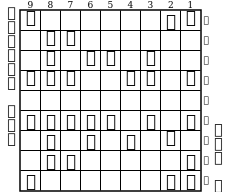

In [83]:
cshogi.Board(feature_to_sfen(images[1]))

l6Rl/1kg6/1s1pg1n2/ppp2sp1p/9/PPPPP1P1P/1SNG1P1+p1/1KG5R/L6NL b Rb2n3ps 1


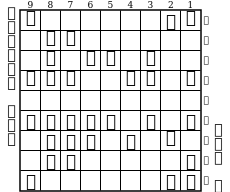

In [84]:
cshogi.Board(feature_to_sfen(recon_images[1] >= 0.2))

lns2g1nl/7s1/1kg1pp3/p5spP/2P1P3p/3p5/1PSP+rP3/2G1RRG2/L3RK1NL b PPSBpp 1


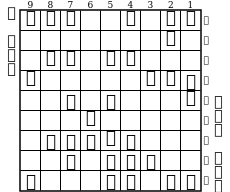

In [34]:
cshogi.Board(feature_to_sfen(model.decode(torch.tensor([[-1.0] +
                                                        [-1.0] +
                                                        [ 0.0] * 30]).to(device))[0] >= 0.3))

In [38]:
mu.shape

torch.Size([1024, 32])

In [37]:
mu

tensor([[-0.0312,  0.0961, -0.4589,  ...,  0.1143,  0.0120,  0.0478],
        [-0.5582,  0.1016, -0.7813,  ..., -0.2749, -0.2569,  0.0791],
        [-0.0481, -0.0778, -1.4169,  ...,  0.7834,  0.6987,  0.9784],
        ...,
        [-0.9261,  0.2531,  0.3214,  ...,  0.4424, -0.2740, -0.6580],
        [-0.1296, -0.2741,  0.2564,  ...,  0.1536,  0.3149,  0.0700],
        [-0.5453,  0.4395,  0.1509,  ...,  0.0348,  0.7415,  0.0311]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [51]:
mu_array = mu.to("cpu").detach().numpy().copy()
logvar_array = logvar.to("cpu").detach().numpy().copy()

In [52]:
mu_array

array([[-0.03116895,  0.09606416, -0.45885488, ...,  0.11425114,
         0.01196776,  0.04782528],
       [-0.55821615,  0.10160431, -0.78126323, ..., -0.27492422,
        -0.2569024 ,  0.07907915],
       [-0.04807115, -0.07779863, -1.4169095 , ...,  0.7833998 ,
         0.6986828 ,  0.9783821 ],
       ...,
       [-0.9261464 ,  0.25313967,  0.32138565, ...,  0.44236007,
        -0.27396968, -0.65795517],
       [-0.12964796, -0.2741047 ,  0.25635588, ...,  0.15361165,
         0.31486616,  0.06999856],
       [-0.5453048 ,  0.4394605 ,  0.15087865, ...,  0.03482062,
         0.7414653 ,  0.03109005]], dtype=float32)

In [75]:
mu_array[:, 0]

(1024,)

In [53]:
logvar_array

array([[-11.695546 , -11.47556  , -10.858607 , ..., -11.114387 ,
        -11.686764 , -11.546114 ],
       [-10.93209  , -11.482684 , -11.3237295, ..., -11.052278 ,
        -11.07042  , -11.016209 ],
       [-11.698398 , -12.249292 , -11.619015 , ..., -11.768077 ,
        -11.230839 , -11.581539 ],
       ...,
       [ -9.091452 ,  -8.794303 ,  -8.904379 , ...,  -9.070538 ,
         -9.285251 ,  -8.459456 ],
       [ -5.26632  ,  -5.359856 ,  -5.0167394, ...,  -5.4993033,
         -4.642695 ,  -5.305957 ],
       [-11.814639 , -11.00372  , -10.747329 , ..., -11.399979 ,
        -10.653002 , -11.306767 ]], dtype=float32)

In [50]:
np.mean(mu_array, axis=0)

array([ 0.01013029, -0.00442813,  0.09099923,  0.02716033,  0.00290174,
        0.05306146, -0.02746906,  0.03336127, -0.01863843, -0.08760817,
        0.01450957, -0.4778579 , -0.00173737,  0.0166963 , -0.14535545,
        0.19593905, -0.01138943, -0.05605406, -0.04551715,  0.19208997,
       -0.12839611, -0.10117371, -0.02829558,  0.01192548,  0.03084222,
        0.07516784, -0.03315178, -0.04132252, -0.20444576,  0.14983305,
       -0.01117215, -0.00645858], dtype=float32)

In [78]:
np.std(mu_array, axis=0)

array([0.4749192 , 0.41946778, 0.4688424 , 0.42142877, 0.42661348,
       0.5112217 , 0.41857064, 0.44275308, 0.45149478, 0.50526047,
       0.40324202, 0.7293292 , 0.42715016, 0.43499306, 0.3840515 ,
       0.47259614, 0.44317043, 0.47130457, 0.41716957, 0.4382077 ,
       0.45589244, 0.44631755, 0.4172362 , 0.40588674, 0.4346073 ,
       0.3928251 , 0.44619864, 0.4053746 , 0.63603026, 0.42362472,
       0.46566513, 0.40903145], dtype=float32)

In [55]:
np.mean(logvar_array, axis=0)

array([-10.531998 , -10.409695 , -10.017707 , -10.331973 , -10.343841 ,
       -10.012288 , -10.465398 , -10.4610195, -10.416925 , -10.572544 ,
       -10.491721 ,  -9.69454  , -10.498241 , -10.524045 , -10.344489 ,
       -10.405791 , -10.520129 , -10.550792 , -10.49068  , -10.621861 ,
        -9.507733 , -10.408053 , -10.356194 , -10.554286 , -10.23968  ,
        -9.91394  , -10.466632 , -10.259953 ,  -9.769326 , -10.415932 ,
       -10.300576 , -10.326369 ], dtype=float32)

In [79]:
np.std(logvar_array, axis=0)

array([1.8987119, 2.0287244, 1.9396048, 1.9639621, 1.871972 , 1.9331014,
       1.9142087, 1.9487749, 1.9814293, 2.0683143, 1.9676502, 1.943792 ,
       1.8579594, 1.914634 , 2.128182 , 1.9073561, 2.0127099, 2.0012355,
       1.9262724, 1.926236 , 2.1645043, 2.0422454, 1.9813428, 1.8985184,
       1.9017287, 1.9123207, 1.9334525, 2.1411984, 1.805638 , 1.820266 ,
       2.011389 , 1.9685575], dtype=float32)

In [68]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt


In [76]:
tsne = TSNE(n_components=2, random_state=42)
mu_tsne = tsne.fit_transform(mu_array[:, 0])


ValueError: Expected 2D array, got 1D array instead:
array=[-0.03116895 -0.55821615 -0.04807115 ... -0.9261464  -0.12964796
 -0.5453048 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

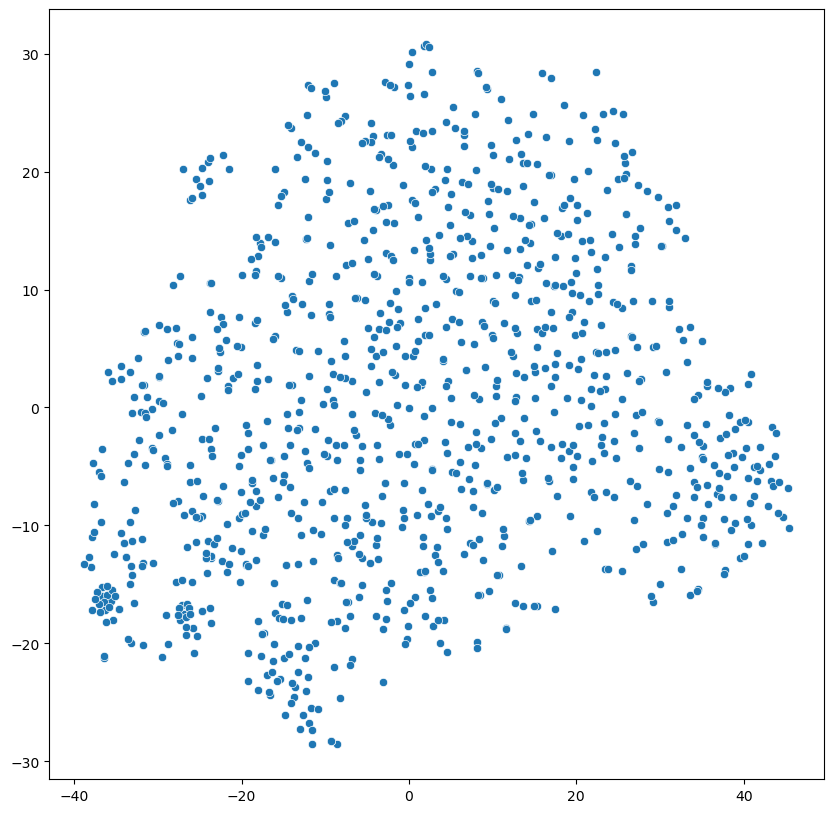

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=mu_tsne[:, 0], y=mu_tsne[:, 1])
plt.show()

In [77]:
np.e ** (-10)

4.5399929762484875e-05